In [ ]:
import pandas as pd
from scipy.stats import describe
import numpy as np
import matplotlib.pyplot as plt

from hurst import compute_Hc, random_walk
from scipy import stats
import os

def extract_col(x):
    if min(x)>0:
        return True
    else:
        return False
    

In [ ]:
df = pd.read_csv("C:\My Work Documents\Dissertation\pythonCodeVersions\ABC_HFT_Git\Simulated data\out_test.csv")
df = pd.DataFrame(df)
df.shape
df.columns = range(df.shape[1])
df

In [ ]:
param = pd.read_csv("C:\My Work Documents\Dissertation\pythonCodeVersions\ABC_HFT_Git\Simulated data\param_test.csv")
param = param.transpose()
param.columns = range(df.shape[1])
param_pos = param.loc[:, df.apply(extract_col, axis = 0)]

In [ ]:
df

plt.plot(df[23],color="C0", label='Simulation')
#print(param1_pos[x])

In [ ]:
df_pos = df.loc[:, df.apply(extract_col, axis = 0)]
df_pos = np.log(df_pos)
df_pos.columns = range(0,df_pos.shape[1])
df_pos

In [ ]:
p_true = pd.read_csv("C:\My Work Documents\Dissertation\pythonCodeVersions\p_true.csv")
p_true = pd.DataFrame(p_true)

p_true = pd.read_csv("C:\My Work Documents\Dissertation\Dissertation Data\Original_Price_Bars_2300.csv", 
                              header=None)
p_true = pd.DataFrame(p_true)
p_true


In [ ]:
param_pos

In [116]:
def summary_stats_extra(x):
    """outputs additional summary statistics: skewness, kurtosis, Hurst"""

    try:
        H, c, data = compute_Hc(x, kind='price', simplified=True)
    except Exception as e:
        H = 0.25
        print(e)
        
    # count, mean, std, min, 25%, 50%, 75%, max
    s1 = x.describe()
    
    # Kolmogorov Smirnov 2 sample test statistic (if 0 - identical)
    ks_stat = {"KS": stats.ks_2samp(np.ravel(x), np.ravel(np.log(p_true)))[0]}
    
    return {"mean": s1.loc["mean"],
            "std": np.log(s1.loc["std"]),
            "skew": x.skew(),
            "kurt": x.kurt(),
            "hurst": H,
            **ks_stat}



In [117]:
def summarise_price_path(price_path, islog = False):
    percentiles = [0,.1, .25, .3, .4, .5, .6, .7, .8, .9, 1.0]
    price_path_t = price_path.copy()
    
    # log prices if not yet logged
    if islog == False:
        price_path_t = np.log(price_path_t)
        
    SS1 = summary_stats_extra(price_path_t)
    SS1_df = pd.DataFrame(list(SS1.items()), columns=['SS_name', 'SS'])
    #print(SS1_df)
    
    
    price_path_t = pd.DataFrame(price_path_t)
    SS2 = price_path_t.quantile(percentiles)

    SS2 = SS2.diff().iloc[1:].values
    
    SS2 = pd.DataFrame(SS2)
    SS2 = pd.DataFrame(np.mean(SS2.iloc[[1,8]]))
    
    SS2_name = np.array(range(1)) 
    SS2_df = pd.DataFrame(np.hstack((SS2_name.T[:,None],SS2.iloc[:,0].values[:,None])), columns = ['SS_name', 'SS'])
    dfs = [SS1_df, SS2_df]
    dfs = pd.concat(dfs)
    
    arr = dfs["SS"]
    
    return(arr)
    
        

In [ ]:
SS_true = p_true.apply(summarise_price_path, islog =False, axis = 0)
SS_true


In [ ]:
SS = df_pos.apply(summarise_price_path, islog =True, axis = 0)


In [ ]:
SS.index = ["mean", "std", "Skew", "Kurt", "Hurst", "KS", "diff_percentile"]


In [ ]:
# SS transformations
SS_trans = SS.T[np.multiply((SS.loc["Kurt"]<2) , (SS.loc["diff_percentile"]<0.005))].T
param_pos_trans = param_pos.T.iloc[SS_trans.columns].T
SS_trans.loc["diff_percentile"] = np.log(SS_trans.loc["diff_percentile"]+1)
SS_trans.loc["diff_percentile"] = (SS_trans.loc["diff_percentile"]-np.mean(SS_trans.loc["diff_percentile"]))/np.std(SS_trans.loc["diff_percentile"])

In [ ]:
SS_trans.to_csv(os.path.join("C:\My Work Documents\Dissertation\pythonCodeVersions", 'SS_options_test.csv'), index=False)
param_pos_trans.to_csv(os.path.join("C:\My Work Documents\Dissertation\pythonCodeVersions", 'param_options_test.csv'), index=False)
SS_true.to_csv(os.path.join("C:\My Work Documents\Dissertation\pythonCodeVersions", 'SS_true_options_test.csv'), index=False)


In [ ]:
sns.set(style="ticks")
dft = pd.DataFrame(np.vstack((param_pos_trans,SS_trans)))
#[param_pos_trans.loc["delta"], SS_trans]
np.concatenate((param_pos_trans.index, SS_trans.index))
dft.index = np.concatenate((param_pos_trans.index, SS_trans.index))

delta_df = dft.drop(["C_lambda", "delta_S", "delta", "mu","lambda_0"])
sns.pairplot(delta_df.T)

In [ ]:
sns.set(style="ticks")


sns.pairplot(SS_trans.iloc[([0,1,2,3,4,5,7,14])].T)


In [ ]:
sns.set(style="ticks")


#sns.pairplot()
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 20
plt.matshow(SS_trans.T.corr())
plt.xticks(range(len(SS_trans.T.columns)), SS_trans.T.columns, fontsize=14)
plt.yticks(range(len(SS_trans.T.columns)), SS_trans.T.columns, fontsize=14)
plt.colorbar()
plt.show()

In [ ]:
# plot
from scipy.stats import norm


from scipy import stats
SS_test = SS
SS[(np.abs(stats.zscore(SS)) < 3).all(axis=1)]
#(np.abs(stats.zscore(SS.T)) < 3).all()
S_kurt = SS.loc["Kurt"][SS.loc["Kurt"]<2]


f, axes = plt.subplots(2, 3, sharex=False, figsize=(7, 7))
sns.distplot( SS.loc["mean"] , color="olive", ax=axes[0, 0], fit=norm)
sns.distplot( np.log(SS.loc["std"]) , color="olive", ax=axes[0, 1], fit=norm)
sns.distplot( (SS.loc["Skew"]) , color="olive", ax=axes[0, 2], fit=norm)
sns.distplot( (S_kurt) , color="olive", ax=axes[1, 0], fit=norm)
sns.distplot( (SS.loc["Hurst"]) , color="olive", ax=axes[1, 1], fit=norm)
sns.distplot( (SS.loc["KS"]) , color="olive", ax=axes[1, 2],fit=norm)

In [ ]:
# f, axes = plt.subplots(2, 3, sharex=False, figsize=(7, 7))
sns.distplot( param_pos.loc["delta"] , color="skyblue", ax=axes[0, 0], fit=norm)
sns.distplot( param_pos.loc["mu"] , color="olive", ax=axes[0, 1])
sns.distplot( param_pos.loc["alpha"] , color="gold", ax=axes[0, 2])
sns.distplot( param_pos.loc["lambda_0"] , color="teal", ax=axes[1, 0])
sns.distplot( param_pos.loc["C_lambda"] , color="teal", ax=axes[1, 1])
sns.distplot( param_pos.loc["delta_S"] , color="teal", ax=axes[1, 2])

In [ ]:
f, axes = plt.subplots(5, 2, sharex=False, figsize=(7, 7))
sns.distplot( np.log(SS.loc["1"][stats.zscore(SS.loc["1"])< 2]+1) , color="skyblue", ax=axes[0, 0], fit=norm)
sns.distplot( np.log(SS.loc["2"][stats.zscore(SS.loc["2"])< 2]+1) , color="olive", ax=axes[1, 0], fit=norm)
sns.distplot( np.log(SS.loc["3"][stats.zscore(SS.loc["3"])< 2]+1) , color="gold", ax=axes[2, 0], fit=norm)
sns.distplot( np.log(SS.loc["4"][stats.zscore(SS.loc["4"])< 2]+1) , color="teal", ax=axes[3, 0], fit=norm)
sns.distplot( np.log(SS.loc["5"][stats.zscore(SS.loc["5"])< 2]+1) , color="teal", ax=axes[4, 0], fit=norm)
sns.distplot( np.log(SS.loc["6"][stats.zscore(SS.loc["6"])< 2]+1) , color="teal", ax=axes[0, 1], fit=norm)
sns.distplot( np.log(SS.loc["7"][stats.zscore(SS.loc["7"])< 2]+1) , color="gold", ax=axes[1, 1], fit=norm)
sns.distplot( np.log(SS.loc["8"][stats.zscore(SS.loc["7"])< 2]+1) , color="teal", ax=axes[2, 1], fit=norm)
sns.distplot( np.log(SS.loc["9"][stats.zscore(SS.loc["8"])< 2]+1) , color="teal", ax=axes[3, 1], fit=norm)
sns.distplot( np.log(SS.loc["10"][stats.zscore(SS.loc["9"])< 2]+1) , color="teal", ax=axes[4, 1], fit=norm)

In [ ]:
SS.loc["10"][26]

## Regression Lasso

In [89]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib
from scipy.stats import skew
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from scipy.stats.stats import pearsonr
%matplotlib inline
from subprocess import check_output
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

In [90]:
sim_sum_stats = pd.read_csv("C:\My Work Documents\Dissertation\pythonCodeVersions\SS_options_sqr.csv").T.iloc[1:]
sim_param = pd.read_csv("C:\My Work Documents\Dissertation\pythonCodeVersions\param_options_test.csv")


X = sim_sum_stats.T ## X usually means our input variables (or independent variables)
X.columns = ["mean", "std", "Skew", "Kurt", "Hurst", "KS", "diff_percentile", 
                    "mean2", "std2", "Skew2", "Kurt2", "Hurst2", "KS2", "diff_percentile2"]

sim_param.rename(index ={0:"delta", 1:"mu", 2:"alpha", 3:"lambda0", 4:"C_lambda", 5:"delta_S"}, inplace=True)

y = sim_param ## Y usually means our output/dependent variable
#X_scaled = sm.add_constant(X_scaled) ## let's add an intercept (beta_0) to our model
y = y.loc["delta_S"]

In [91]:
from sklearn.model_selection import train_test_split

X_train = X
y_train = y



0.013970465361678916


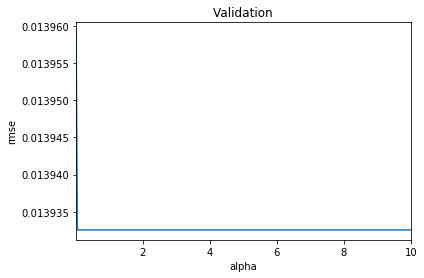

In [92]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)


alphas_try = [0.01, 0.05, 0.1, 0.3, 0.8, 1, 2, 5, 10]
cv_ridge = [rmse_cv(Lasso(alpha = alpha)).mean() 
            for alpha in alphas_try]
cv_ridge = pd.Series(cv_ridge, index = alphas_try)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")
cv_ridge.min()

# ###Model Lasso regression
###Model Lasso regression
model_lasso = LassoCV(alphas = [10, 1, 0.1, 0.001, 0.0005], max_iter=10000,cv=10).fit(X_train, y_train)
print(rmse_cv(model_lasso).mean())
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
coef
cv_ridge = pd.DataFrame(np.vstack([cv_ridge,alphas_try]).T, index=alphas_try)
#plt.plot(cv_ridge[1], cv_ridge[0])
#plt.show()
#cv_ridge[0]
#np.array(alphas_try)
#cv_ridge


In [93]:
print("Lasso picked " + str(sum(coef != 0)) + 
      " variables and eliminated the other " +  
      str(sum(coef == 0)) + " variables")


Lasso picked 0 variables and eliminated the other 14 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

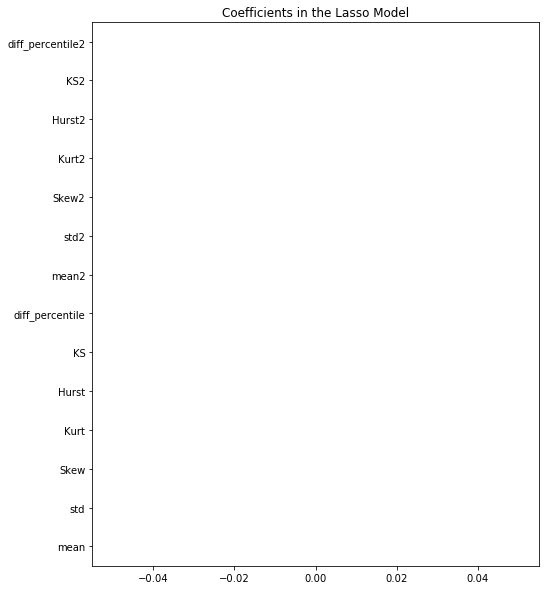

In [94]:
imp_coef = pd.concat([coef.sort_values().head(7),
                     coef.sort_values().tail(7)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [112]:
import statsmodels.api as sm # import statsmodels 
y_train = pd.DataFrame(y_train)
# Note the difference in argument order
X_train = sm.add_constant(X_train)

# X_train = X_train[np.array([ "const", "std",
#                             "diff_percentile2" ])].astype(float)
X_train = X_train.T.drop( "KS").T.astype(float)
#X_train = X_train.astype(float)
#model = LinearRegression().fit(X_train, y_train)
model = sm.OLS(np.array(y_train), X_train).fit() ## sm.OLS(output, input)
predictions = model.predict(X_train)
#y_train.shape
#X_train.shape
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     4.159
Date:                Sun, 12 Jan 2020   Prob (F-statistic):             0.0162
Time:                        15:58:27   Log-Likelihood:                 1319.6
No. Observations:                 461   AIC:                            -2633.
Df Residuals:                     458   BIC:                            -2621.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0266      0.001     20.728      0.000       0.024       0.029
Kurt           0.0029      0.001      2.459      0.014       0.001       0.005
Skew2         -0.0051      0.002     -2.691      0.007      -0.009      -0.001
==============================================================================
Omnibus:                      120.216   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.780
Skew:                           0.184   Prob(JB):                     6.86e-06
Kurtosis:                       1.950   Cond. No.                         4.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

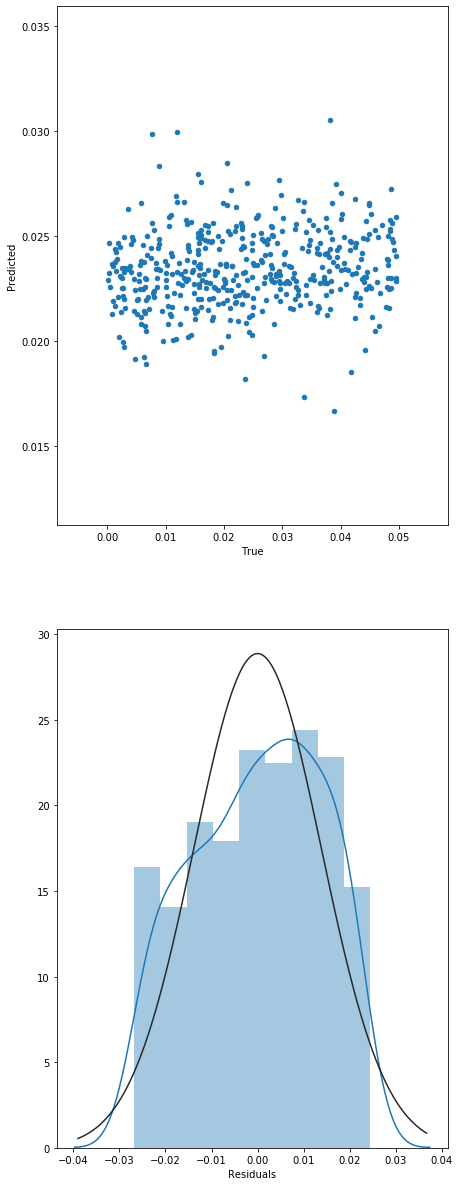

In [113]:
from scipy.stats import norm

f, axes = plt.subplots(2, 1, sharex=False, figsize=(7, 21))


#matplotlib.rcParams['figure.figsize'] = (6, 6.0)
preds = pd.DataFrame({"Predicted":model.predict(X_train).values, "True":y_train.T.values[0]})
preds["Residuals"] = np.subtract(preds["Predicted"], preds["True"])
#preds.plot(x = "predicted", y = "residuals",kind = "scatter", ax=axes[ 1])
preds.plot(x="True", y="Predicted", kind="scatter", ax=axes[ 0])
# import seaborn as sns
#preds
ax = sns.distplot((preds["Residuals"]), fit=norm, ax=axes[ 1])
plt.show()
#np.subtract(model.predict(X_train).values, y_train.T.values)[0]


In [ ]:
preds["true"][456]
X_train.iloc[456].values

In [119]:
p_true = pd.read_csv("C:\My Work Documents\Dissertation\Dissertation Data\Original_Price_Bars_2300.csv", 
                              header=None)
p_true = pd.DataFrame(p_true)
p_true

,0
0,238.745
1,238.720
2,238.720
3,238.675
4,238.675
...,...
2295,254.085
2296,254.065
2297,254.175
2298,254.065
